This notebook demonstrates how to extract subsets of data where the cruise control is OFF. You should use the provided function at the top of the notebook as your helper in your code.

In [173]:
import signal
import pandas as pd
import sys, math, time, datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
from matplotlib.pyplot import cm
import pickle
from strym import strymread
import strym
import copy

This function returns a dataframe where information is removed if the ACC is engaged. An example that calls it is below, and demonstrates how the two streams of data do not match in places where the ACC is on, which is basically

```
r1 = removeACC(r0)
```

In [181]:
# removes the times during which the ACC is on and engaged, and returns a new strym object
def removeACC(strym_obj):
    frames = []
    
    timeslices = strym_obj.time_subset(conditions="cruise control on")
    df = strym_obj.dataframe
    # we have times when ACC is on, now we need to remove those times, so if 
    # our drive is from t0 to tN
    # acc is on from t1 to t2, t8 to t30, t50 to t65 ,then we'll have 
    # ( (t1, t2), (t8, t30), (t50, t65))
    # so we'll look to KEEP times
    # (0, t1), (t2, t8), (t30, t50), (t65, -1) 
#     print('Timeslices of acc on are:', timeslices)
    if len(timeslices) < 1:
#         print('Appending frames no matter what')
        frames.append(df)
    else:
        # always set the first one before the loop
#         print('doing the first one')
        import datetime as dt
        frame = df.loc[ pd.Timestamp(df.Time[0]) : timeslices[0][0][0]]
        frames.append(frame)
        for ii in range(len(timeslices[0])):
#             if ii == 0:
#             elif ii == len(timeslices[0])-1:
#                 frame = df.loc[ timeslices[0][ii][1] : ]
#             else:
            if ii > 0:
#                 print('doing a middle one from time ', timeslices[0][ii-1][1], ' to ', timeslices[0][ii][0])
                frame = df.loc[ timeslices[0][ii-1][1] : timeslices[0][ii][0]]
                frames.append(frame)
        # always do the last one
#         print('doing the last one')
        frame = df.loc [ timeslices[0][len(timeslices)-1][1]:pd.Timestamp(df.Time[-1]) ]
        frames.append(frame)
#     print(frames)
    # return the new dataframe(s), using style from strym
    result = copy.deepcopy(strym_obj)
    result_frames = pd.concat(frames)
    result.dataframe = result_frames
    return result, timeslices[0]

An example call is below.

In [184]:
# change this to your data folder
# datafolder='/Users/sallykim/Desktop/2021_08_09/'
datafolder='/Users/sprinkle/work/data/sally/2021_08_09/'
# datafolder='/Users/sallykim/Desktop/2021_08_09/'

import glob
csvlist = glob.glob(datafolder+"*2T3*CAN*.csv")

num_of_files = len(csvlist)
print("Total number of datafiles in {} is {}.".format(datafolder, num_of_files))
# dbcfile = '../examples/newToyotacode.dbc'

Total number of datafiles in /Users/sprinkle/work/data/sally/2021_08_09/ is 3.


In [185]:
# choose the first file, and then plot the speed, as well as the lead vehicle distance
# Look in Minitest 1 or in 

#dbcfile_17 = '/Users/sallykim/opt/miniconda3/lib/python3.9/site-packages/strym/dbc/toyota_rav4_hybrid.dbc'
datafile_17 = csvlist[0]
datafile_17 = csvlist[1]
# datafile_17 = datafolder+'2021-08-09-17-42-45_2T3Y1RFV8KC014025_CAN_Messages.csv'
# datafile_17 = csvlist[2]
#data_17 = pd.read_csv(datafile_17)



In [190]:
r0 = strymread(datafile_17)
# make the call to get the new dataframe r1, which also returns the times that were removed
r1,removed = removeACC(r0)
# optionally, retrieve the times that were removed like this:
# r1,removed = removeACC(r0)




[2022_07_20_18_13_36] (root) INFO: Vehicle model infered is toyota-rav4-2019


[Text(0.5, 31.722222222222207, 'Time (s) from start of drive'),
 Text(138.47222222222223, 0.5, 'Speed (km/hr) + 10'),
 Text(0.5, 1.0, 'Speed vs. Time (10mph added to original df)')]

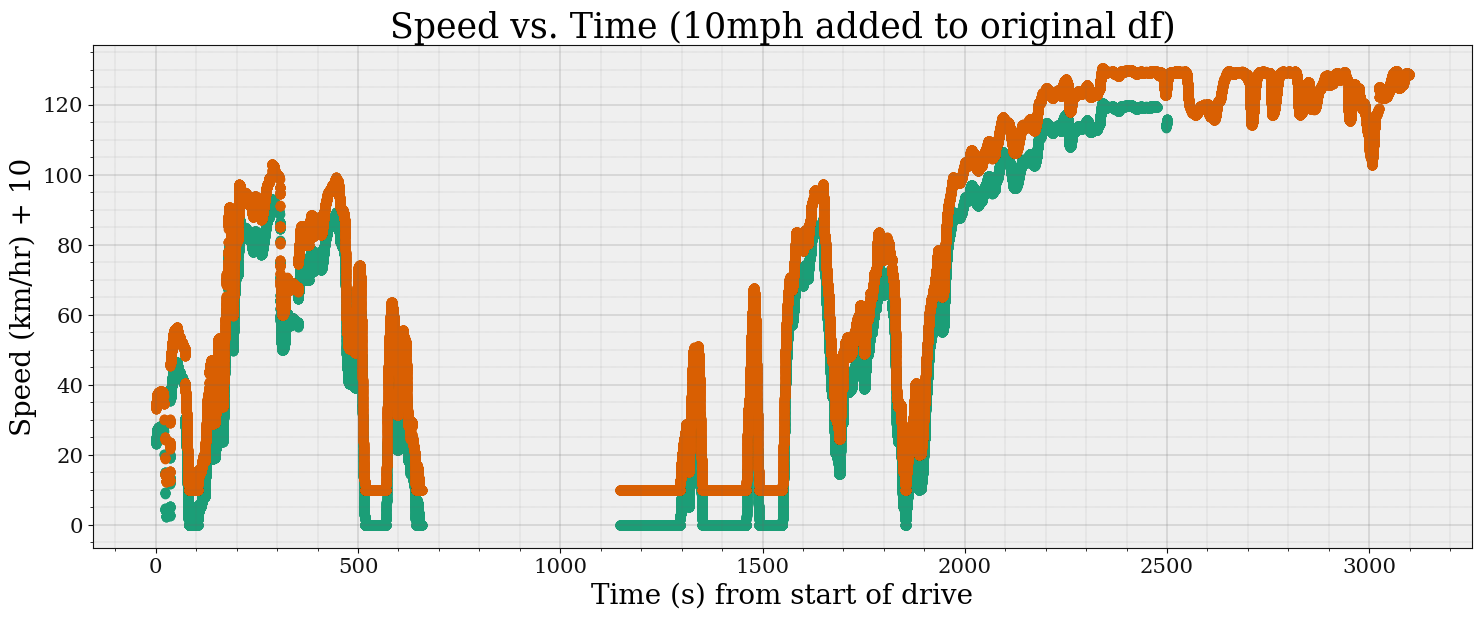

In [191]:
r0_speed = r0.speed()
r1_speed = r1.speed()

fig, ax = strymread.create_fig(1)
ax[0].scatter(x=r1_speed['Time'] - r1_speed['Time'][0],y=r1_speed['Message'])
ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr)',title='Speed vs. Time')
ax[0].scatter(x=r0_speed['Time'] - r0_speed['Time'][0],y=r0_speed['Message']+10)
ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr) + 10',title='Speed vs. Time (10mph added to original df)')

Turning each of the dataframe segments into a chunk for easier visualization:


In [208]:
# here we use 'Time' as the column of interest, and create a new dataframe if time skips more than 5 seconds
r1_speeds = strymread.create_chunks(r1_speed,continuous_threshold=5.0,column_of_interest='Time')

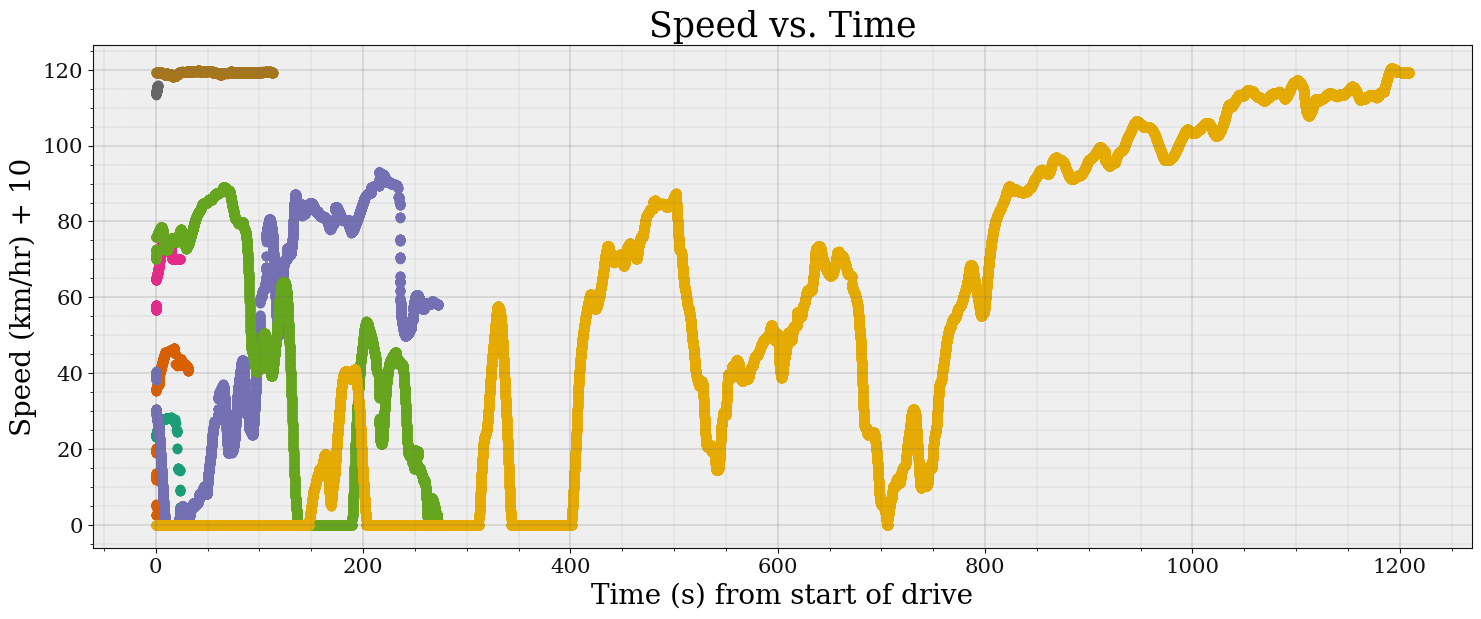

In [209]:
fig, ax = strymread.create_fig(1)
for speed in r1_speeds:
    ax[0].scatter(x=speed['Time'] - speed['Time'][0],y=speed['Message'])
    ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr) + 10',title='Speed vs. Time')

# Prototyping code is below.
You can ignore these pieces.

In [108]:
r0 = strymread(datafile_17)
speed = r0.speed()
try:
    speed_17 = r0.get_ts('SPEED','SPEED')
    long_dist_17 = r0.get_ts('LEAD_INFO','LEAD_LONG_DIST')
    long_dist_17_2 = r0.lead_distance()
except:
    print('Oops, a specific error message Sally writes')

[2022_07_20_17_30_46] (root) INFO: Vehicle model infered is toyota-rav4-2019


In [109]:
times = r0.time_subset(conditions="cruise control on")

In [110]:
times

[[(Timestamp('2021-08-09 18:24:00.133018112'),
   Timestamp('2021-08-09 18:24:23.161307136')),
  (Timestamp('2021-08-09 18:24:24.972029952'),
   Timestamp('2021-08-09 18:34:21.976162048'))]]

In [111]:
range(len(times[0]))

range(0, 2)

In [112]:
times[0][1][0]

Timestamp('2021-08-09 18:24:24.972029952')

In [113]:
# r1 = r0
# r1 = r1.dataframe.loc[times[0][0][0]: times[0][0][1]]

In [114]:
long_dist_17_2['Time']

Clock
2021-08-09 17:42:45.278156032    1.628531e+09
2021-08-09 17:42:45.477657088    1.628531e+09
2021-08-09 17:42:45.677645056    1.628531e+09
2021-08-09 17:42:45.877929984    1.628531e+09
2021-08-09 17:42:46.077857024    1.628531e+09
                                     ...     
2021-08-09 18:34:22.770638848    1.628534e+09
2021-08-09 18:34:22.970938880    1.628534e+09
2021-08-09 18:34:23.170820096    1.628534e+09
2021-08-09 18:34:23.371165952    1.628534e+09
2021-08-09 18:34:23.570708992    1.628534e+09
Name: Time, Length: 13826, dtype: float64

In [115]:
long_dist_17_2_noacc_start = long_dist_17_2.loc[: times[0][0][0]]
long_dist_17_2_noacc_middle = long_dist_17_2.loc[times[0][0][1]: times[0][1][0]]
long_dist_17_2_noacc_end = long_dist_17_2.loc[times[0][1][1]:]




In [116]:
long_dist_17_2_noacc_start

,Time,Message
Clock,,
2021-08-09 17:42:45.278156032,1.628531e+09,252
2021-08-09 17:42:45.477657088,1.628531e+09,252
2021-08-09 17:42:45.677645056,1.628531e+09,252
2021-08-09 17:42:45.877929984,1.628531e+09,252
2021-08-09 17:42:46.077857024,1.628531e+09,252
...,...,...
2021-08-09 18:23:59.152142080,1.628533e+09,252
2021-08-09 18:23:59.352050944,1.628533e+09,252
2021-08-09 18:23:59.552582912,1.628533e+09,252


In [117]:
long_dist_17_2_noacc_middle

,Time,Message
Clock,,
2021-08-09 18:24:23.353319936,1.628533e+09,252
2021-08-09 18:24:23.552845056,1.628533e+09,252
2021-08-09 18:24:23.753103104,1.628533e+09,252
2021-08-09 18:24:23.952696064,1.628533e+09,252
2021-08-09 18:24:24.152656128,1.628533e+09,252
2021-08-09 18:24:24.152801024,1.628533e+09,252
2021-08-09 18:24:24.352992000,1.628533e+09,252
2021-08-09 18:24:24.553241088,1.628533e+09,252
2021-08-09 18:24:24.752852992,1.628533e+09,252


In [118]:
long_dist_17_2_noacc_end

,Time,Message
Clock,,
2021-08-09 18:34:22.170955776,1.628534e+09,252
2021-08-09 18:34:22.370716160,1.628534e+09,252
2021-08-09 18:34:22.571213056,1.628534e+09,76
2021-08-09 18:34:22.770638848,1.628534e+09,75
2021-08-09 18:34:22.970938880,1.628534e+09,75
2021-08-09 18:34:23.170820096,1.628534e+09,74
2021-08-09 18:34:23.371165952,1.628534e+09,73
2021-08-09 18:34:23.570708992,1.628534e+09,73


In [119]:
len(times[0])

2

In [120]:
times[0][0][1]

Timestamp('2021-08-09 18:24:23.161307136')

In [121]:
testTimes = r0.time_subset(conditions="cruise control on")
print(testTimes)

[[(Timestamp('2021-08-09 18:24:00.133018112'), Timestamp('2021-08-09 18:24:23.161307136')), (Timestamp('2021-08-09 18:24:24.972029952'), Timestamp('2021-08-09 18:34:21.976162048'))]]


In [167]:
# removes the times during which the ACC is on and engaged, and returns a new strym object
def removeACC(strym_obj):
    frames = []
    
    timeslices = strym_obj.time_subset(conditions="cruise control on")
    df = strym_obj.dataframe
    # we have times when ACC is on, now we need to remove those times, so if 
    # our drive is from t0 to tN
    # acc is on from t1 to t2, t8 to t30, t50 to t65 ,then we'll have 
    # ( (t1, t2), (t8, t30), (t50, t65))
    # so we'll look to KEEP times
    # (0, t1), (t2, t8), (t30, t50), (t65, -1) 
    print('Timeslices of acc on are:', timeslices)
    if len(timeslices) < 1:
        print('Appending frames no matter what')
        frames.append(df)
    else:
        # always set the first one before the loop
        print('doing the first one')
        import datetime as dt
        frame = df.loc[ pd.Timestamp(df.Time[0]) : timeslices[0][0][0]]
        frames.append(frame)
        for ii in range(len(timeslices[0])):
#             if ii == 0:
#             elif ii == len(timeslices[0])-1:
#                 frame = df.loc[ timeslices[0][ii][1] : ]
#             else:
            if ii > 0:
                print('doing a middle one from time ', timeslices[0][ii-1][1], ' to ', timeslices[0][ii][0])
                frame = df.loc[ timeslices[0][ii-1][1] : timeslices[0][ii][0]]
                frames.append(frame)
        # always do the last one
        print('doing the last one')
        frame = df.loc [ timeslices[0][len(timeslices)-1][1]:pd.Timestamp(df.Time[-1]) ]
        frames.append(frame)
    print(frames)
    # return the new dataframe(s), using style from strym
    result = copy.deepcopy(strym_obj)
    result_frames = pd.concat(frames)
    result.dataframe = result_frames
    return result, timeslices[0]

In [168]:
r0_speed = r0.speed()

[Text(0.5, 31.722222222222207, 'Time (s) from start of drive'),
 Text(138.47222222222223, 0.5, 'Speed (km/hr) + 10'),
 Text(0.5, 1.0, 'Speed vs. Time (original df)')]

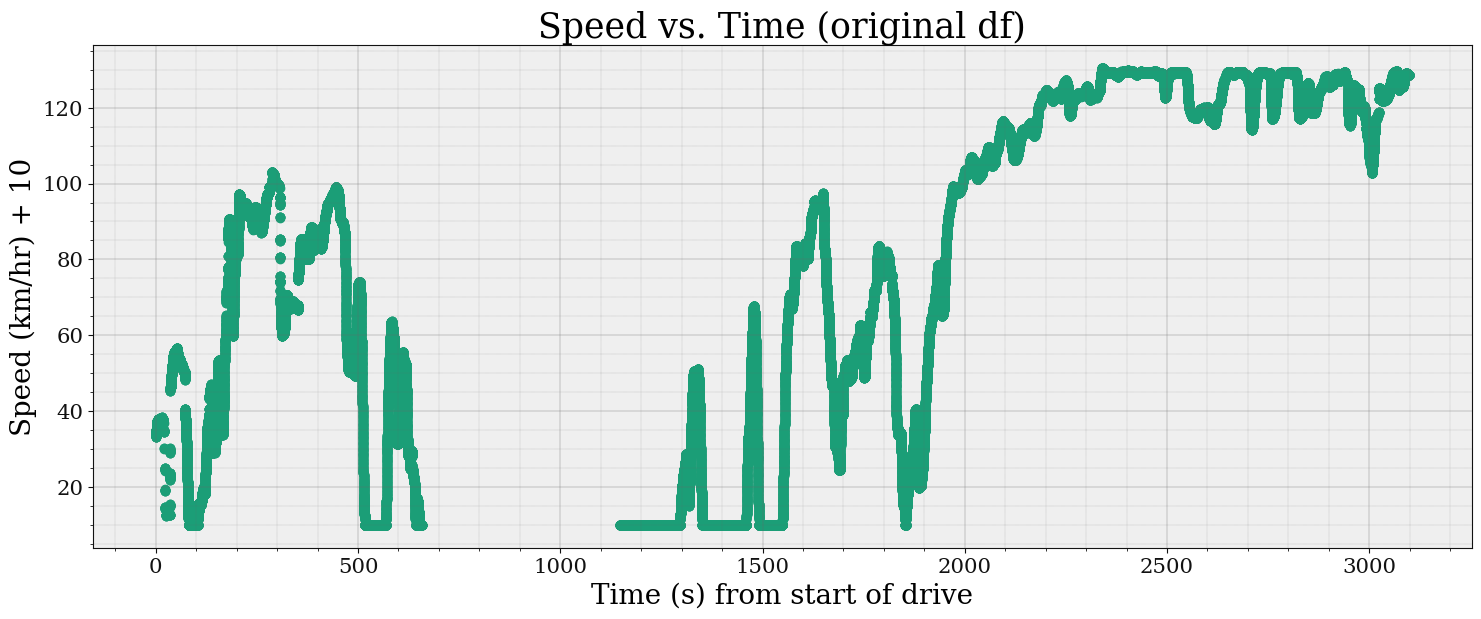

In [169]:
fig, ax = strymread.create_fig(1)
ax[0].scatter(x=r0_speed['Time'] - r0_speed['Time'][0],y=r0_speed['Message']+10)
ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr) + 10',title='Speed vs. Time (original df)')

In [170]:
r1,removed = removeACC(r0)

Timeslices of acc on are: [[(Timestamp('2021-08-09 18:24:00.133018112'), Timestamp('2021-08-09 18:24:23.161307136')), (Timestamp('2021-08-09 18:24:24.972029952'), Timestamp('2021-08-09 18:34:21.976162048'))]]
doing the first one
doing a middle one from time  2021-08-09 18:24:23.161307136  to  2021-08-09 18:24:24.972029952
doing the last one
[                                       Time  Bus  MessageID           Message  \
Clock                                                                           
2021-08-09 17:42:45.174656000  1.628531e+09    1        436  030cef1b001b3b2c   
2021-08-09 17:42:45.174861824  1.628531e+09    1        437  037ffc00000ffc47   
2021-08-09 17:42:45.175664896  1.628531e+09    2        170  23b1235d23a9235d   
2021-08-09 17:42:45.175664896  1.628531e+09    0        170  23b1235d23a9235d   
2021-08-09 17:42:45.175664896  1.628531e+09    1        438  037ffc00000ffc48   
...                                     ...  ...        ...               ...   
2021-08-

In [171]:
r1_speed = r1.speed()


[Text(0.5, 31.722222222222207, 'Time (s) from start of drive'),
 Text(138.47222222222223, 0.5, 'Speed (km/hr) + 10'),
 Text(0.5, 1.0, 'Speed vs. Time (original df)')]

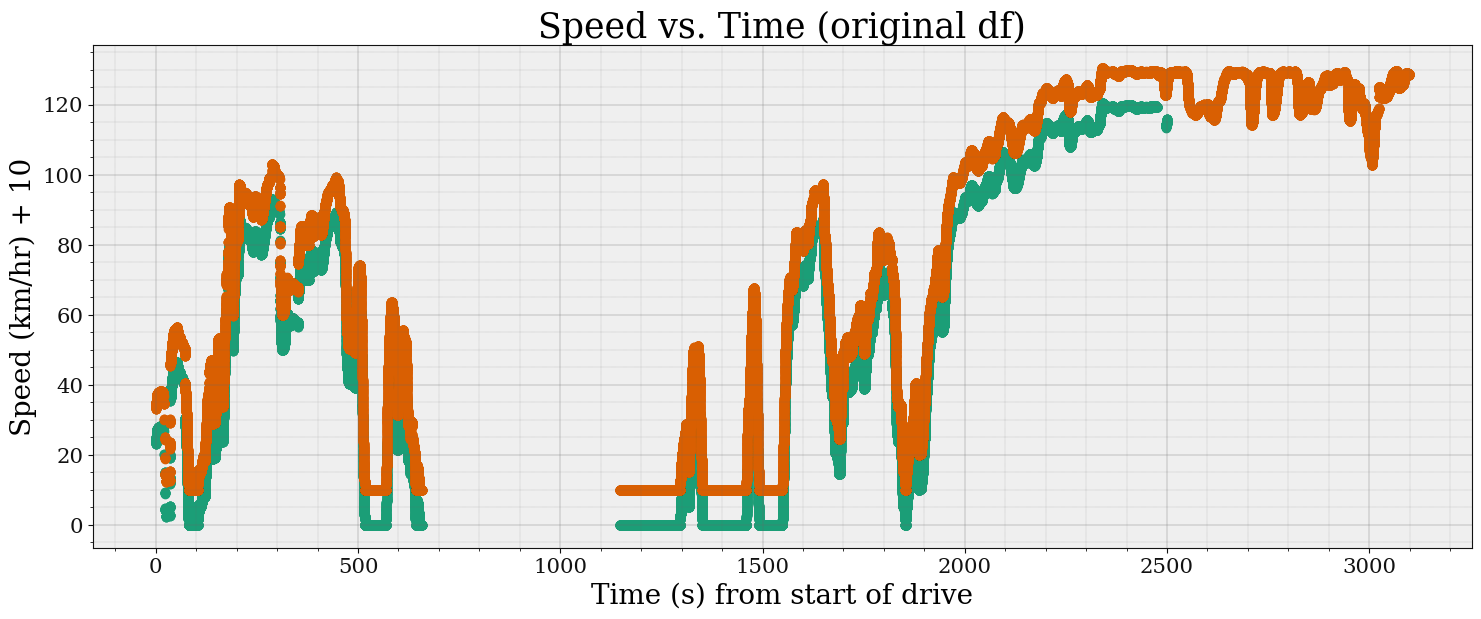

In [172]:
fig, ax = strymread.create_fig(1)
ax[0].scatter(x=r1_speed['Time'] - r1_speed['Time'][0],y=r1_speed['Message'])
ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr)',title='Speed vs. Time')
ax[0].scatter(x=r0_speed['Time'] - r0_speed['Time'][0],y=r0_speed['Message']+10)
ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr) + 10',title='Speed vs. Time (original df)')

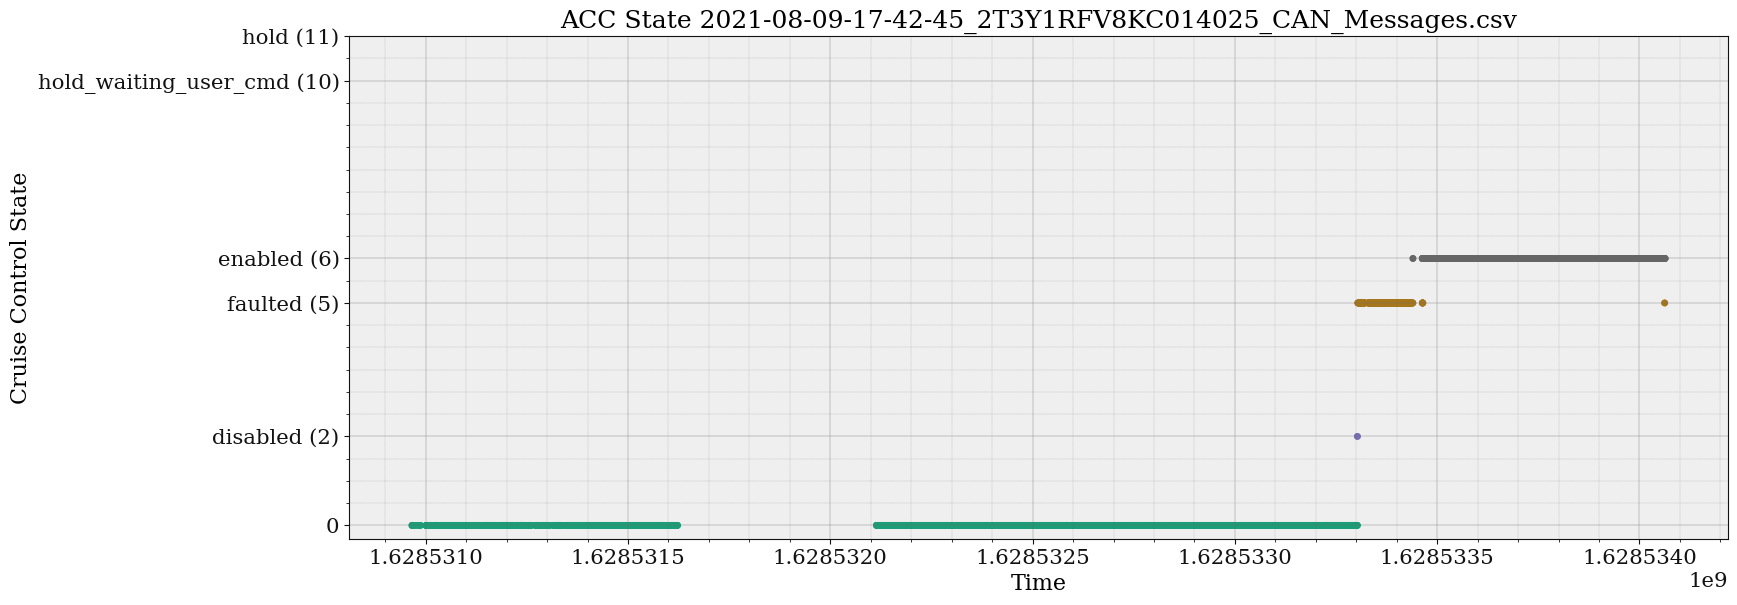

In [148]:
statplot = r1.acc_state(plot=True)